<a href="https://www.kaggle.com/code/ibnarahat/heart-disease-predictor?scriptVersionId=272231196" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 1️⃣ IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, accuracy_score
)

# 2️⃣ LOAD DATASET

In [2]:
data_path = "/kaggle/input/heart-disease-data/heart_disease_uci.csv"

df = pd.read_csv(data_path)
print("# Data Loaded Successfully!")
print("Shape:", df.shape)
df.head()


# Data Loaded Successfully!
Shape: (920, 16)


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0



# 3️⃣ CLEANING & TARGET SELECTION

# # Remove identifiers or irrelevant columns

In [3]:
cols_to_drop = [c for c in ['id', 'dataset'] if c in df.columns]
df = df.drop(columns=cols_to_drop, errors='ignore')

# # Detect target column automatically

In [4]:
possible_targets = ['target', 'num', 'HeartDisease', 'heart_disease']
target_col = next((col for col in possible_targets if col in df.columns), df.columns[-1])

# # Separate features and target

In [5]:
X = df.drop(columns=[target_col])
y = df[target_col]

# # Convert multi-class to binary (0 = no disease, 1 = disease)

In [6]:
if set(y.unique()) - {0, 1}:
    y = (y > 0).astype(int)
    print("* Converted target to binary classes (0/1).")

* Converted target to binary classes (0/1).


# 4️⃣ FEATURE PROCESSING

# # Separate numeric and categorical columns

In [7]:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# # Attempt to convert numeric-like strings

In [8]:
for c in cat_cols:
    temp = pd.to_numeric(X[c], errors='coerce')
    if temp.notnull().mean() > 0.9:
        X[c] = temp

# # Update lists after conversion

In [9]:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# # Impute numeric columns (median)

In [10]:
num_imputer = SimpleImputer(strategy='median')
X_num = pd.DataFrame(num_imputer.fit_transform(X[num_cols]), columns=num_cols)

# # Encode categorical columns (one-hot)

In [11]:
if cat_cols:
    X_cat = pd.get_dummies(X[cat_cols].fillna("missing"), drop_first=True)
    X_final = pd.concat([X_num, X_cat], axis=1)
else:
    X_final = X_num

print("\n# Final processed feature matrix shape:", X_final.shape)


# Final processed feature matrix shape: (920, 21)


# 5️⃣ TRAIN / TEST SPLIT

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y
)

# # Scale numeric features (optional but improves stability)

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6️⃣ MODEL TRAINING — RANDOM FOREST

In [14]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_scaled, y_train)
print("\n🌳 Random Forest Model Trained Successfully!")


🌳 Random Forest Model Trained Successfully!


# 7️⃣ MODEL EVALUATION

In [15]:
y_pred = rf.predict(X_test_scaled)
y_proba = rf.predict_proba(X_test_scaled)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f"\n# Accuracy: {acc:.4f}")
print(f"# ROC-AUC: {auc:.4f}")
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, digits=4))


# Accuracy: 0.8424
# ROC-AUC: 0.9116

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.8533    0.7805    0.8153        82
           1     0.8349    0.8922    0.8626       102

    accuracy                         0.8424       184
   macro avg     0.8441    0.8363    0.8389       184
weighted avg     0.8431    0.8424    0.8415       184



# 8️⃣ VISUALIZATION

# # Confusion Matrix

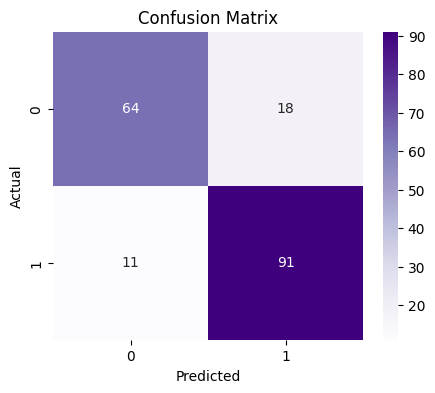

In [16]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, cmap="Purples", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# # ROC Curve

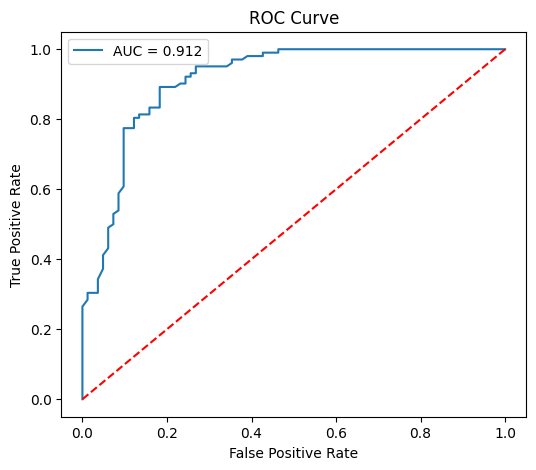

In [17]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], 'r--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# 9️⃣ FEATURE IMPORTANCE


# Top 10 Important Features:
               Feature  Importance
2                 chol    0.137030
4               thalch    0.126117
0                  age    0.114065
6              oldpeak    0.105707
5                exang    0.092581
1             trestbps    0.076190
9   cp_atypical angina    0.060273
8             sex_Male    0.036656
15          slope_flat    0.033506
19         thal_normal    0.029850


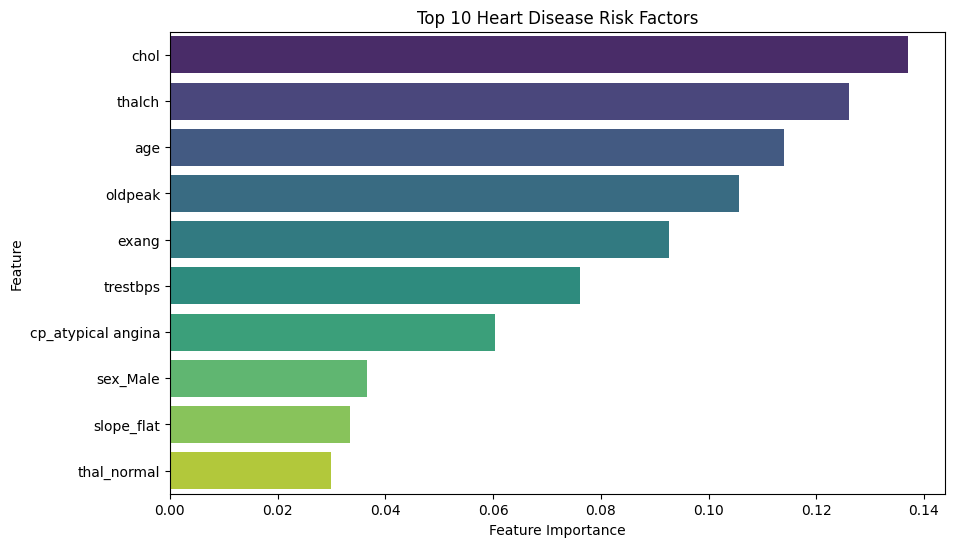

In [18]:
importance_df = pd.DataFrame({
    "Feature": X_final.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\n# Top 10 Important Features:")
print(importance_df.head(10))

plt.figure(figsize=(10,6))
sns.barplot(data=importance_df.head(10), x="Importance", y="Feature", palette="viridis")
plt.title("Top 10 Heart Disease Risk Factors")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()

# # SUMMARY

In [19]:
print("\n Model Summary:")
print(f"Total Samples: {len(df)}")
print(f"Features Used: {X_final.shape[1]}")
print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC: {auc:.4f}")
print("\nMost influential factors are likely:")
print(", ".join(importance_df.head(5)["Feature"].tolist()))


 Model Summary:
Total Samples: 920
Features Used: 21
Accuracy: 0.8424
ROC-AUC: 0.9116

Most influential factors are likely:
chol, thalch, age, oldpeak, exang
